## Import required packages

In [1]:
# import libraries for reading data, exploring and plotting
!pip install numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional


## Loading and Analysis of Data

In [2]:
# Reading the dataset
messages=pd.read_csv("/kaggle/input/sms-dataset/SMSSpamCollection",sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
# Dmessages.groupby('label').describe().Tisplaying the statistics 
messages.describe()


,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
# To display the duplicate rows
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [5]:
#To checke whether data is balanced or not
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [6]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

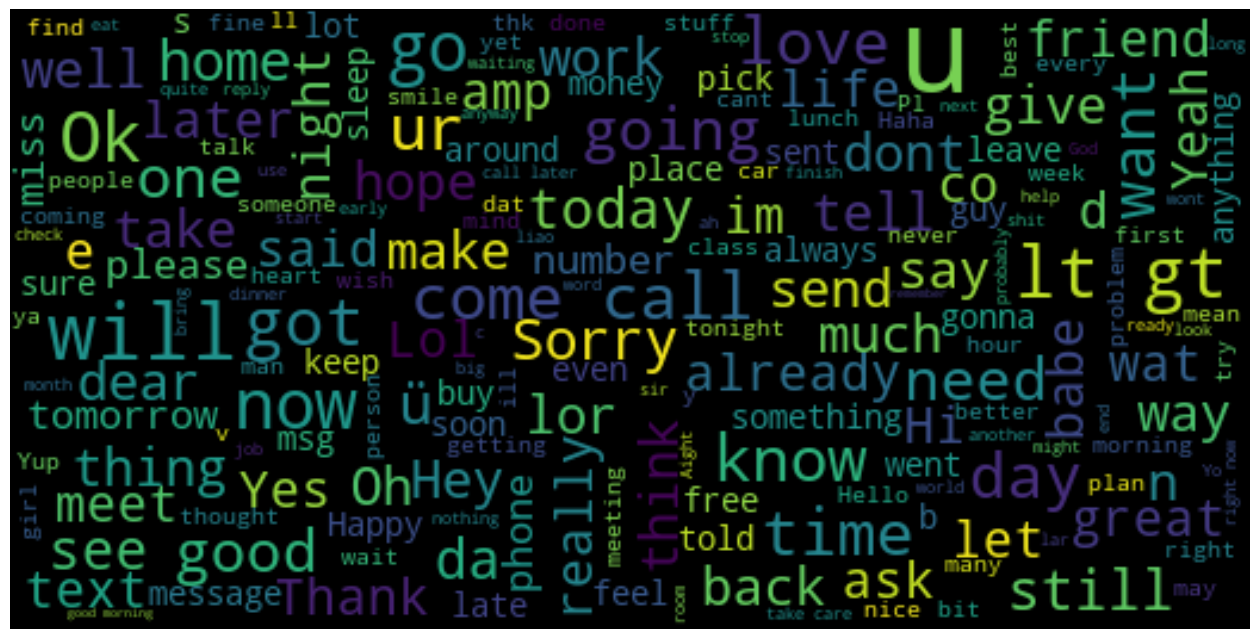

In [7]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black").generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

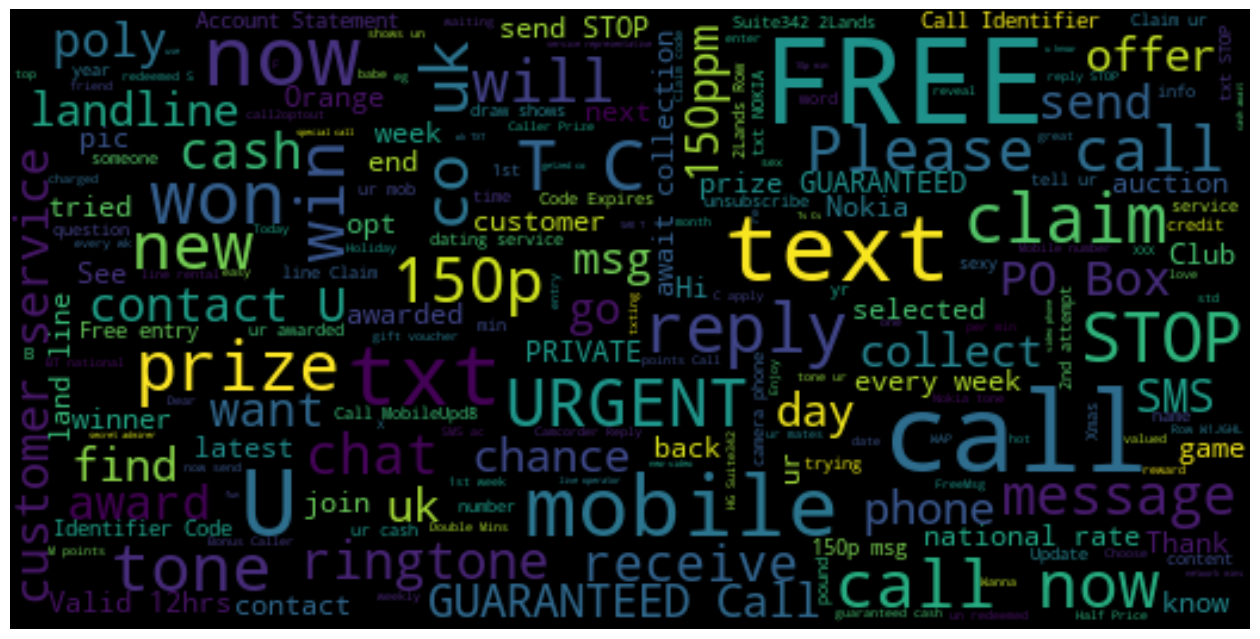

In [8]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black").generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095

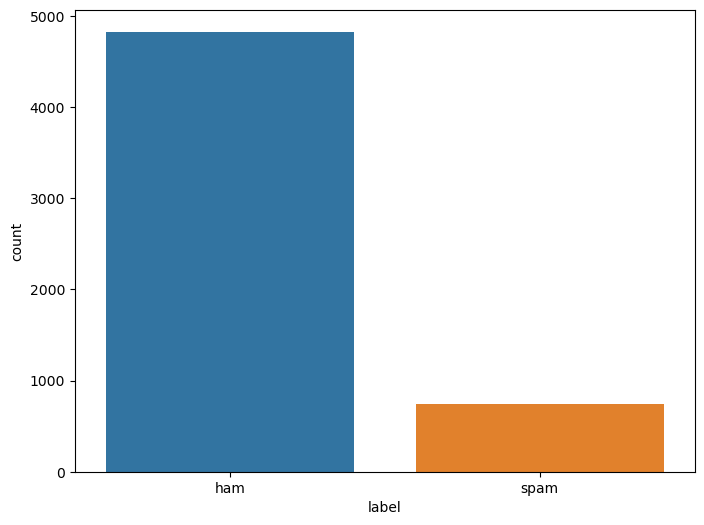

In [9]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(x=messages.label,data=messages)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

In [10]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


Text(0.5, 0, 'Message types')

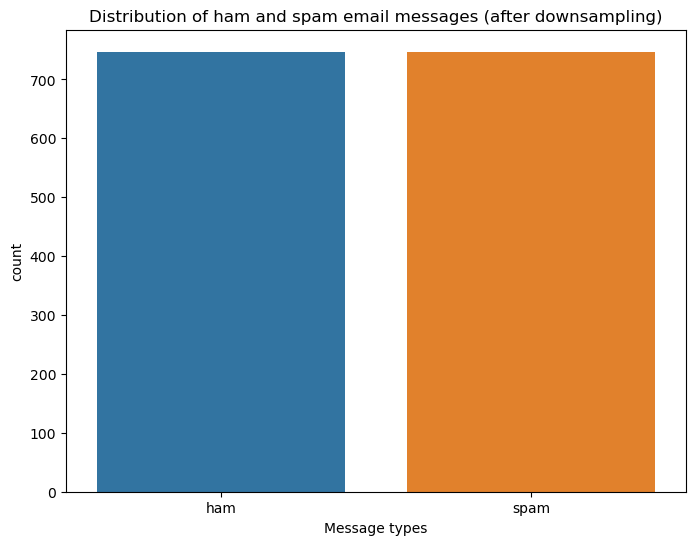

In [11]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(x=msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [12]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

#Average length of ham is 73 and that of spam is 138

,text_length
label,
ham,73.238286
spam,138.670683


## Test-Train spliltting and Pre-processing

In [13]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

### Tokenization

In [14]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [15]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [16]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


### Sequencing & Padding

In [17]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [18]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [19]:
# Before padding length
print(len(training_sequences[0]), len(training_sequences[1]))
# After padding length
print(len(training_padded[0]), len(training_padded[1]))

27 24
50 50


## Dense Spam Detection Model

In [20]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
# fitting a dense spam detector model
num_epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model.save('Dense_Spam_Detection.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [21]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)


10/10 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.9365


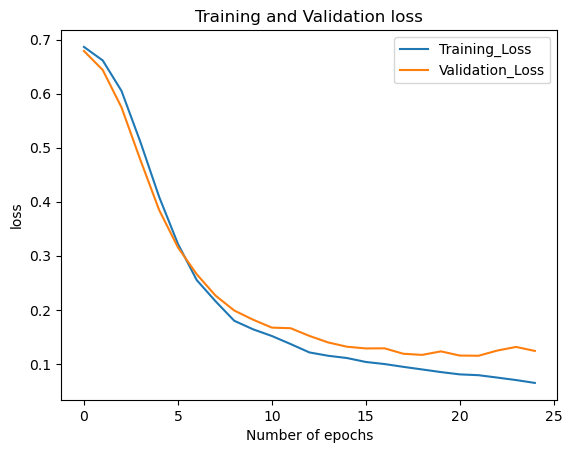

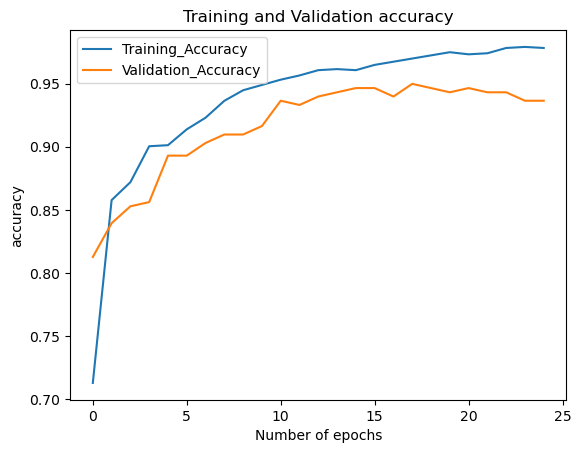

In [22]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Long Short Term Memory (LSTM) Model

In [23]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm))#return_sequences=True is giving error due to wrong dimensions 
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model1.save('LSTM_Spam_Detection.h5')

Epoch 1/30
38/38 - 4s - loss: 0.6933 - accuracy: 0.4828 - val_loss: 0.6934 - val_accuracy: 0.4783 - 4s/epoch - 101ms/step
Epoch 2/30
38/38 - 1s - loss: 0.6154 - accuracy: 0.6494 - val_loss: 0.3964 - val_accuracy: 0.9130 - 756ms/epoch - 20ms/step
Epoch 3/30
38/38 - 1s - loss: 0.3593 - accuracy: 0.9088 - val_loss: 0.3052 - val_accuracy: 0.9097 - 741ms/epoch - 19ms/step
Epoch 4/30
38/38 - 1s - loss: 0.2272 - accuracy: 0.9423 - val_loss: 0.3197 - val_accuracy: 0.9130 - 747ms/epoch - 20ms/step
Epoch 5/30
38/38 - 1s - loss: 0.1970 - accuracy: 0.9498 - val_loss: 0.2367 - val_accuracy: 0.9331 - 776ms/epoch - 20ms/step
Epoch 6/30
38/38 - 1s - loss: 0.1701 - accuracy: 0.9565 - val_loss: 0.1858 - val_accuracy: 0.9498 - 740ms/epoch - 19ms/step
Epoch 7/30
38/38 - 1s - loss: 0.1562 - accuracy: 0.9615 - val_loss: 0.2159 - val_accuracy: 0.9431 - 744ms/epoch - 20ms/step
Epoch 8/30
38/38 - 1s - loss: 0.1570 - accuracy: 0.9615 - val_loss: 0.3211 - val_accuracy: 0.9164 - 739ms/epoch - 19ms/step
Epoch 9/30

In [24]:
model1.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 6ms/step - loss: 0.1618 - accuracy: 0.9532


[0.16179989278316498, 0.953177273273468]

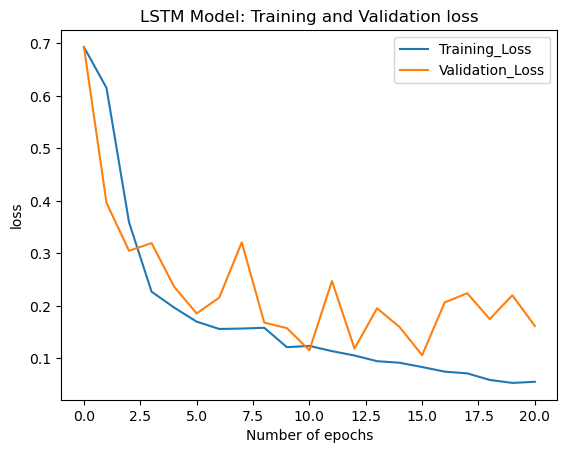

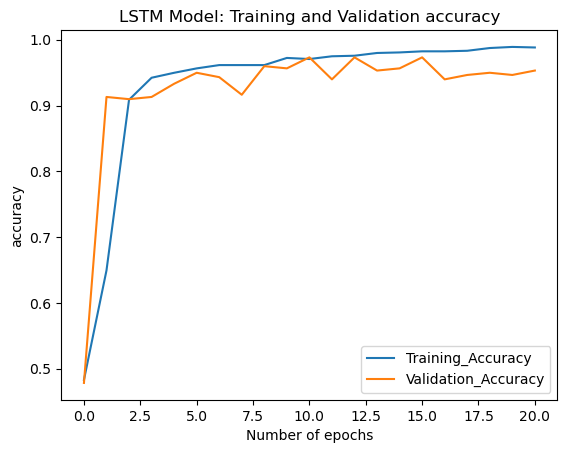

In [25]:
# Create a dataframe
metrics = pd.DataFrame(history.history)# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Support Vector Machine

In [26]:
from sklearn.svm import SVC

# SVC hyperparameters
C = 10
gamma = 0.1
kernel = 'rbf'

# SVM Spam detection
svm_model = SVC(C=C, gamma=gamma, kernel=kernel)
svm_model.fit(training_padded, train_labels)
score = svm_model.score(testing_padded, test_labels)

print("Accuracy:", score)


Accuracy: 0.6956521739130435


In [27]:
model1.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 0.9532


[0.16179989278316498, 0.953177273273468]

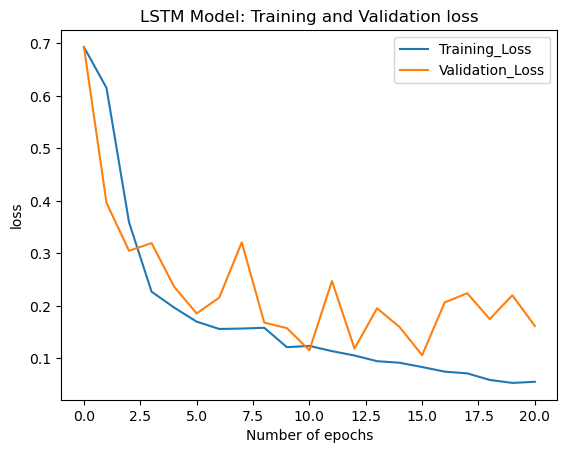

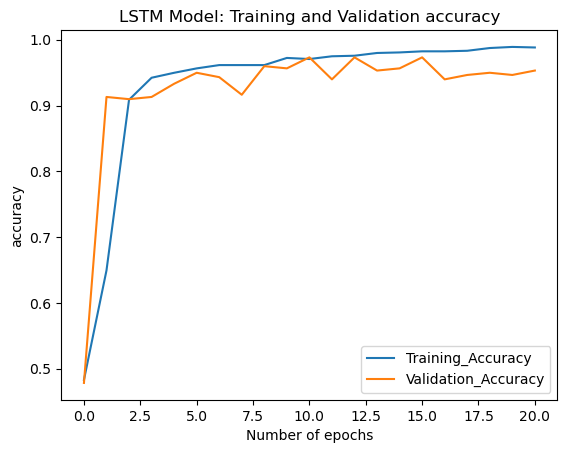

In [28]:
# Create a dataframe
metrics = pd.DataFrame(history.history)# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Bi-directional Long Short Term Memory (BiLSTM) Model

In [29]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
model2.save('BiLSTM_Spam_Detection.h5')

Epoch 1/30
38/38 - 6s - loss: 0.6840 - accuracy: 0.5975 - val_loss: 0.6455 - val_accuracy: 0.8696 - 6s/epoch - 164ms/step
Epoch 2/30
38/38 - 1s - loss: 0.5229 - accuracy: 0.8444 - val_loss: 0.4202 - val_accuracy: 0.8462 - 987ms/epoch - 26ms/step
Epoch 3/30
38/38 - 1s - loss: 0.3250 - accuracy: 0.8946 - val_loss: 0.2322 - val_accuracy: 0.9097 - 931ms/epoch - 25ms/step
Epoch 4/30
38/38 - 1s - loss: 0.1665 - accuracy: 0.9481 - val_loss: 0.1427 - val_accuracy: 0.9465 - 954ms/epoch - 25ms/step
Epoch 5/30
38/38 - 1s - loss: 0.1264 - accuracy: 0.9623 - val_loss: 0.1309 - val_accuracy: 0.9465 - 964ms/epoch - 25ms/step
Epoch 6/30
38/38 - 1s - loss: 0.1030 - accuracy: 0.9674 - val_loss: 0.1661 - val_accuracy: 0.9431 - 942ms/epoch - 25ms/step
Epoch 7/30
38/38 - 1s - loss: 0.0816 - accuracy: 0.9791 - val_loss: 0.0993 - val_accuracy: 0.9666 - 944ms/epoch - 25ms/step
Epoch 8/30
38/38 - 1s - loss: 0.0848 - accuracy: 0.9766 - val_loss: 0.1044 - val_accuracy: 0.9565 - 930ms/epoch - 24ms/step
Epoch 9/30

In [30]:
model2.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 0.9498


[0.1489507555961609, 0.9498327970504761]

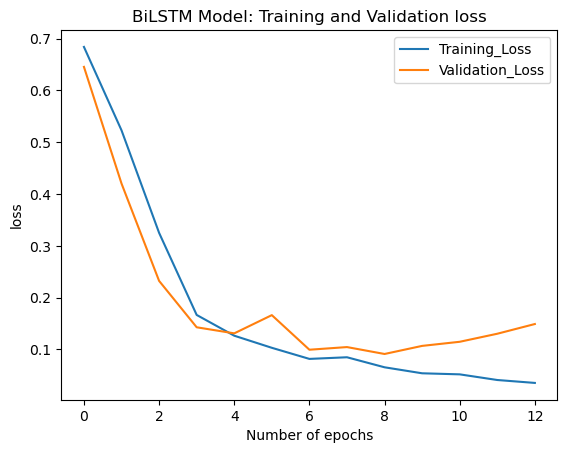

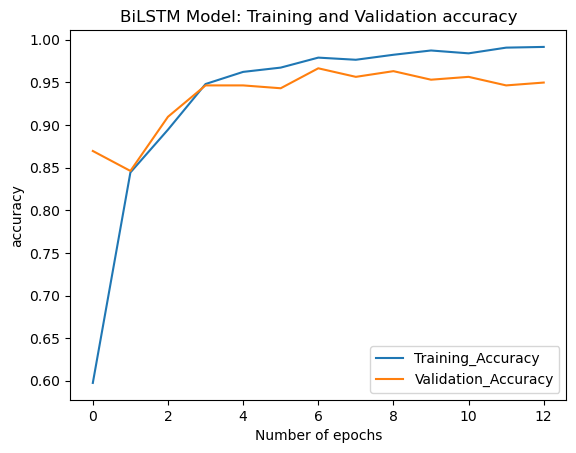

In [31]:
# Create a dataframe
metrics = pd.DataFrame(history.history)# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## The accuracy of the models are as follows:-
### 1) Dense Network
### 2) SVM
### 3) Bi-LSTM
### 4) LSTM